# Neural Style Transfer

This notebook reproduces the neural style transfer algorithm introduced by Gatys, Ecker, and Bethge (2016), blending the structural content of one image with the artistic style of another using a deep convolutional neural network.

## 1. Setup & Imports
Install (if necessary) and import the required libraries, then detect whether a CUDA-capable GPU is available for acceleration.

In [14]:
%pip install --upgrade pip
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
%pip install matplotlib pillow numpy

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import importlib
import subprocess
import sys

REQUIRED_PACKAGES = ['torch', 'torchvision', 'Pillow', 'matplotlib', 'numpy']
for package in REQUIRED_PACKAGES:
    if importlib.util.find_spec(package) is None:
        print(f'Installing missing dependency: {package}')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

plt.style.use('seaborn-v0_8')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMSIZE = 512 if DEVICE.type == 'cuda' else 256

print(f'Torch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if DEVICE.type == 'cuda':
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')
print(f'Using device: {DEVICE}')

Installing missing dependency: Pillow
Torch version: 2.10.0.dev20251031+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5060 Laptop GPU
Using device: cuda


## 2. Image Loading & Preprocessing
Define utility functions to load, preprocess, and visualise images. Input images are resized to a manageable resolution and converted to tensors suitable for PyTorch.

In [16]:
NORMALIZE_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE)
NORMALIZE_STD = torch.tensor([0.229, 0.224, 0.225], device=DEVICE)

def load_image(image_path: Path, max_size: int = IMSIZE) -> torch.Tensor:
    if not image_path.exists():
        raise FileNotFoundError(f'Image not found: {image_path}')

    image = Image.open(image_path).convert('RGB')
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor.to(DEVICE)

def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    image = tensor.detach().cpu().clone().clamp(0, 1)
    image = image.squeeze(0)
    to_pil = transforms.ToPILImage()
    return to_pil(image)

def save_image(tensor: torch.Tensor, output_path: Path) -> None:
    output_path.parent.mkdir(parents=True, exist_ok=True)
    tensor_to_image(tensor).save(output_path)

def show_image(tensor: torch.Tensor, title: str | None = None) -> None:
    plt.figure(figsize=(4, 4))
    plt.imshow(tensor_to_image(tensor))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def show_side_by_side(images: List[Tuple[str, torch.Tensor]]) -> None:
    cols = len(images)
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4))
    if cols == 1:
        axes = [axes]
    for ax, (title, tensor) in zip(axes, images):
        ax.imshow(tensor_to_image(tensor))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def normalize_for_vgg(tensor: torch.Tensor) -> torch.Tensor:
    mean = NORMALIZE_MEAN.view(1, -1, 1, 1)
    std = NORMALIZE_STD.view(1, -1, 1, 1)
    return (tensor - mean) / std

## 3. Model Preparation
Load a pre-trained VGG19 network, freeze its parameters, and expose helper utilities to capture intermediate activations relevant to style and content representations.

In [17]:
STYLE_LAYER_MAP = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1',
}
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
CONTENT_LAYER = 'conv4_2'

def load_vgg19_features() -> torch.nn.Sequential:
    weights = models.VGG19_Weights.DEFAULT
    vgg = models.vgg19(weights=weights).features.to(DEVICE).eval()
    for param in vgg.parameters():
        param.requires_grad_(False)
    return vgg

VGG_FEATURES = load_vgg19_features()

def get_features(image: torch.Tensor, model: torch.nn.Sequential, layer_map: Dict[str, str]) -> Dict[str, torch.Tensor]:
    features: Dict[str, torch.Tensor] = {}
    x = normalize_for_vgg(image)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layer_map:
            features[layer_map[name]] = x
    return features

def gram_matrix(tensor: torch.Tensor) -> torch.Tensor:
    _, channels, height, width = tensor.size()
    features = tensor.view(channels, height * width)
    gram = torch.mm(features, features.t())
    return gram / (channels * height * width)

## 4. Loss Functions
Implement content and style loss helpers that quantify how closely the generated image matches the desired content structure and stylistic textures, respectively.

In [18]:
def calculate_content_loss(generated: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return F.mse_loss(generated, target)

def calculate_style_loss(generated: torch.Tensor, target_gram: torch.Tensor) -> torch.Tensor:
    generated_gram = gram_matrix(generated)
    return F.mse_loss(generated_gram, target_gram)

## 5. Optimization Loop
Optimise the pixels of a generated image (initialised from the content input) so that it simultaneously minimises content and style losses. Hyperparameters control the relative weighting and number of iterations.

In [19]:
def run_style_transfer(
    content_image: torch.Tensor,
    style_image: torch.Tensor,
    num_steps: int = 300,
    style_weight: float = 1e6,
    content_weight: float = 1.0,
    learning_rate: float = 0.02,
 ) -> Tuple[torch.Tensor, Dict[str, List[float]]]:
    style_features = get_features(style_image, VGG_FEATURES, STYLE_LAYER_MAP)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in STYLE_LAYERS}
    content_features = get_features(content_image, VGG_FEATURES, STYLE_LAYER_MAP)
    target_content = content_features[CONTENT_LAYER]

    generated = content_image.clone().requires_grad_(True)
    optimizer = optim.Adam([generated], lr=learning_rate)
    history: Dict[str, List[float]] = {'content': [], 'style': [], 'total': []}
    log_every = max(num_steps // 10, 1)

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        generated_features = get_features(generated, VGG_FEATURES, STYLE_LAYER_MAP)
        content_loss = calculate_content_loss(generated_features[CONTENT_LAYER], target_content)
        style_loss = 0.0
        for layer in STYLE_LAYERS:
            style_loss = style_loss + calculate_style_loss(generated_features[layer], style_grams[layer])
        style_loss = style_loss / len(STYLE_LAYERS)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            generated.clamp_(0, 1)

        history['content'].append(content_loss.item())
        history['style'].append(style_loss.item())
        history['total'].append(total_loss.item())
        if step % log_every == 0 or step == 1:
            print(
                f'Step {step:4d}/{num_steps} | '
                f'Content: {content_loss.item():.2f} '
                f'Style: {style_loss.item():.2f} '
                f'Total: {total_loss.item():.2f}'
            )

    return generated.detach(), history

## 6. Visualisation Utilities
Helper routines to plot loss convergence and to display the content, style, and generated images side-by-side for qualitative comparison.

In [20]:
def plot_loss_curves(history: Dict[str, List[float]]) -> None:
    steps = range(1, len(history['total']) + 1)
    plt.figure(figsize=(10, 4))
    plt.plot(steps, history['content'], label='Content Loss')
    plt.plot(steps, history['style'], label='Style Loss')
    plt.plot(steps, history['total'], label='Total Loss', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_results(content: torch.Tensor, style: torch.Tensor, stylized: torch.Tensor) -> None:
    show_side_by_side([
        ('Content', content),
        ('Style', style),
        ('Stylized', stylized),
    ])

## 7. User Interaction
Set the image paths and optimisation hyperparameters, then execute the full neural style transfer pipeline.

Content image shape: (1, 3, 512, 512)
Style image shape:   (1, 3, 512, 512)


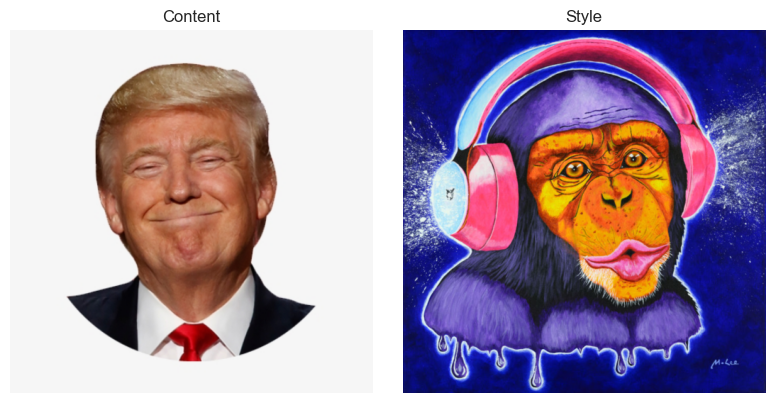

Step    1/300 | Content: 0.00 Style: 0.00 Total: 57.74
Step   30/300 | Content: 2.04 Style: 0.00 Total: 15.23
Step   30/300 | Content: 2.04 Style: 0.00 Total: 15.23
Step   60/300 | Content: 1.69 Style: 0.00 Total: 9.15
Step   60/300 | Content: 1.69 Style: 0.00 Total: 9.15
Step   90/300 | Content: 1.55 Style: 0.00 Total: 6.06
Step   90/300 | Content: 1.55 Style: 0.00 Total: 6.06
Step  120/300 | Content: 1.47 Style: 0.00 Total: 4.55
Step  120/300 | Content: 1.47 Style: 0.00 Total: 4.55
Step  150/300 | Content: 1.42 Style: 0.00 Total: 4.01
Step  150/300 | Content: 1.42 Style: 0.00 Total: 4.01
Step  180/300 | Content: 1.35 Style: 0.00 Total: 3.65
Step  180/300 | Content: 1.35 Style: 0.00 Total: 3.65
Step  210/300 | Content: 1.35 Style: 0.00 Total: 3.47
Step  210/300 | Content: 1.35 Style: 0.00 Total: 3.47
Step  240/300 | Content: 1.31 Style: 0.00 Total: 3.30
Step  240/300 | Content: 1.31 Style: 0.00 Total: 3.30
Step  270/300 | Content: 1.28 Style: 0.00 Total: 3.14
Step  270/300 | Content: 

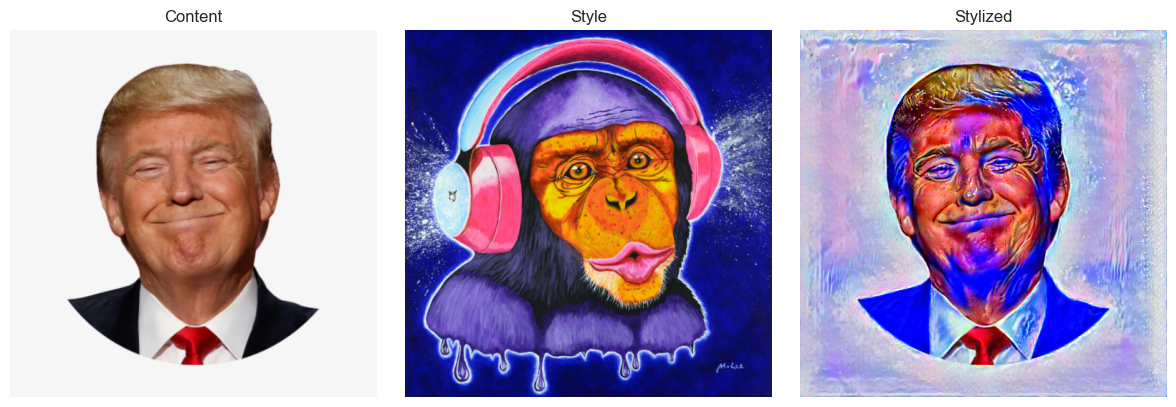

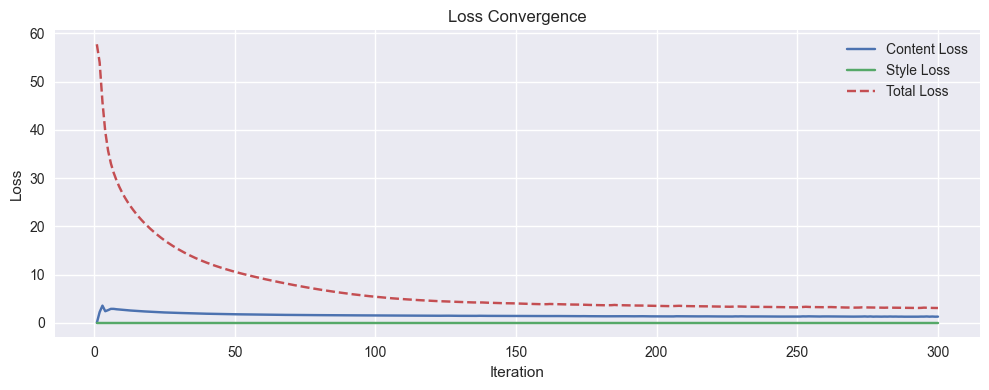

Stylized image saved to: C:\Users\gevor\OneDrive - Concordia University - Canada\Desktop\University\7) FALL 20205\COMP 473\Project\Image-Style-Transfer\images\output_stylized.png


In [23]:
content_path = Path('images/content.png')
style_path = Path('images/style.png')
content_weight = 1.0
style_weight = 1e6
num_steps = 300
learning_rate = 0.02
output_path = Path('images/output_stylized.png')

content_image = load_image(content_path)
style_image = load_image(style_path)

print(f'Content image shape: {tuple(content_image.shape)}')
print(f'Style image shape:   {tuple(style_image.shape)}')
show_side_by_side([
    ('Content', content_image),
    ('Style', style_image),
])

stylized_image, loss_history = run_style_transfer(
    content_image=content_image,
    style_image=style_image,
    num_steps=num_steps,
    style_weight=style_weight,
    content_weight=content_weight,
    learning_rate=learning_rate,
 )

show_results(content_image, style_image, stylized_image)
plot_loss_curves(loss_history)
save_image(stylized_image, output_path)
print(f'Stylized image saved to: {output_path.resolve()}')

## 8. References
- Gatys, L. A., Ecker, A. S., & Bethge, M. (2016). *Image Style Transfer Using Convolutional Neural Networks*. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR).